In [58]:
# Structure:
# Variables: self, periods=30, beginning_balance=1000, beginning_cost=0, div_rate=0.33, st_tax=0.37, lt_tax=0.20, investment_return_rate=0.07, port_turnover=0.25, liquidation=False, st_port_liq = False, st_bench_liq = False
# Calc port (with beginning and end liquidation)
# Store port results
# Calc benchmark and store benchmark results
# Calc breakeven performance
# Plot results
# Display summary results
# Display full results
# Possible corrections: tax cost on early liquidation to include short and long term on realized gain on beginning_balance - beginning cost, 

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

class TaxIllCalculator1:
    def __init__(self, periods=30, beginning_balance=1000, beginning_cost=0, div_rate=0.33, 
                 st_tax=0.37, lt_tax=0.20, investment_return_rate=0.07, port_turnover=0.25, liquidation=False, st_port_liq = False, st_bench_liq = False):
        self.periods = periods
        self.beginning_balance = beginning_balance
        self.beginning_cost = beginning_cost if beginning_cost else beginning_balance
        self.div_rate = div_rate
        self.st_tax = st_tax
        self.lt_tax = lt_tax
        self.investment_return_rate = investment_return_rate
        self.port_turnover = port_turnover
        self.liquidation = liquidation
        self.st_port_liq = st_port_liq
        self.st_bench_liq = st_bench_liq

        self.lt_tax_adj = lt_tax * (1 - port_turnover)
        self.st_tax_adj = st_tax * port_turnover
        
        # Initialize lists for results
        self.results = {
            "portfolio": {
                "beginning_balances": [],
                "investment_returns": [],
                "div_incs": [],
                "beginning_cost_basis": [],
                "realized_gls": [],
                "tax_costs": [],
                "ending_cost_basis": [],
                "ending_balances": []
            },
            "benchmark": {
                "beginning_balances": [],
                "cost_basis": [],
                "investment_returns": [],
                "div_incs": [],
                "realized_gls": [],
                "tax_costs": [],
                "ending_cost_basis": [],
                "ending_balances": []
            }
        }
                
    def calculate_portfolio(self):
        beginning_balance = self.beginning_balance
        beginning_cost = self.beginning_cost

        for i in range(self.periods):
            # Portfolio calculations
            investment_return = beginning_balance * self.investment_return_rate
            div_inc = investment_return * self.div_rate
            realized_gl = (investment_return - div_inc) * self.port_turnover / 2 + (beginning_balance - beginning_cost) * self.port_turnover

            tax_cost = div_inc * self.lt_tax + realized_gl * self.lt_tax_adj + realized_gl * self.st_tax_adj
            ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
            ending_balance = beginning_balance + investment_return - tax_cost

            if i == self.periods - self.periods and self.st_port_liq:
                # Liquidation at the first period
                lrealized_gl =  (beginning_balance - beginning_cost)
                srealized_gl = (investment_return - div_inc) * self.port_turnover / 2
                realized_gl = lrealized_gl + srealized_gl
                tax_cost = div_inc * self.lt_tax + realized_gl * self.lt_tax_adj + realized_gl * self.st_tax_adj
                ending_cost = beginning_cost + srealized_gl + lrealized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost
                
            if i == self.periods - 1 and self.liquidation:
                # Liquidation at the final period
                realized_gl = (investment_return - div_inc) + (beginning_balance - beginning_cost)
                tax_cost = div_inc * self.lt_tax + realized_gl * self.lt_tax_adj + realized_gl * self.st_tax_adj
                ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost

            # Storing the results for portfolio
            self.store_portfolio_results(i, beginning_balance, beginning_cost, investment_return, div_inc, realized_gl, tax_cost, ending_cost, ending_balance)

            # Update balances for the next period
            beginning_balance = ending_balance
            beginning_cost = ending_cost

    def store_portfolio_results(self, i, beginning_balance, beginning_cost, investment_return, div_inc, realized_gl, tax_cost, ending_cost, ending_balance):
        # Store the portfolio results
        self.results["portfolio"]["beginning_balances"].append(beginning_balance)
        self.results["portfolio"]["beginning_cost_basis"].append(beginning_cost)
        self.results["portfolio"]["investment_returns"].append(investment_return)
        self.results["portfolio"]["div_incs"].append(div_inc)
        self.results["portfolio"]["realized_gls"].append(realized_gl)
        self.results["portfolio"]["tax_costs"].append(tax_cost)
        self.results["portfolio"]["ending_cost_basis"].append(ending_cost)
        self.results["portfolio"]["ending_balances"].append(ending_balance)

    def calculate_benchmark(self):
        benchmark_begin_bal = self.beginning_balance
        benchmark_cost = self.beginning_cost

        for i in range(self.periods):
            benchmark_investment_return = benchmark_begin_bal * self.investment_return_rate
            benchmark_div_inc = benchmark_investment_return * self.div_rate
            benchmark_realized_gl = 0  # No realized gain/loss due to zero turnover
            benchmark_tax_cost = benchmark_div_inc * self.lt_tax
            benchmark_end_cost = benchmark_cost + benchmark_div_inc - benchmark_tax_cost
            benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            
            if i == self.periods - self.periods and self.st_bench_liq:
                benchmark_realized_gl = benchmark_begin_bal - benchmark_cost
                benchmark_tax_cost = benchmark_div_inc * self.lt_tax + benchmark_realized_gl * self.lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            
            if i == self.periods - 1 and self.liquidation:
                benchmark_realized_gl = (benchmark_investment_return - benchmark_div_inc) + (benchmark_begin_bal - benchmark_cost)
                benchmark_tax_cost = benchmark_div_inc * self.lt_tax + benchmark_realized_gl * self.lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost

            # Storing the results for benchmark
            self.store_benchmark_results(i, benchmark_begin_bal, benchmark_cost, benchmark_investment_return, benchmark_div_inc, benchmark_realized_gl, benchmark_tax_cost, benchmark_end_cost, benchmark_ending_balance)

            # Update balances for the next period
            benchmark_begin_bal = benchmark_ending_balance
            benchmark_cost = benchmark_end_cost

    def store_benchmark_results(self, i, benchmark_begin_bal, benchmark_cost, benchmark_investment_return, benchmark_div_inc, benchmark_realized_gl, benchmark_tax_cost, benchmark_end_cost, benchmark_ending_balance):
        # Store the benchmark results
        self.results["benchmark"]["beginning_balances"].append(benchmark_begin_bal)
        self.results["benchmark"]["cost_basis"].append(benchmark_cost)
        self.results["benchmark"]["investment_returns"].append(benchmark_investment_return)
        self.results["benchmark"]["div_incs"].append(benchmark_div_inc)
        self.results["benchmark"]["realized_gls"].append(benchmark_realized_gl)
        self.results["benchmark"]["tax_costs"].append(benchmark_tax_cost)
        self.results["benchmark"]["ending_cost_basis"].append(benchmark_end_cost)
        self.results["benchmark"]["ending_balances"].append(benchmark_ending_balance)

    def calculate_breakeven_performance(self):
        # Required Breakeven Performance Calculation
        required_return_rate = self.investment_return_rate
        tolerance = 1e-6  # Convergence tolerance
        max_iterations = 1000

        beginning_balance = self.results["portfolio"]["beginning_balances"][0]
        beginning_cost = self.results["portfolio"]["beginning_cost_basis"][0]
        benchmark_ending_balance = self.results["benchmark"]["ending_balances"][-1]
        periods = self.periods

        for _ in range(max_iterations):
            test_balance = beginning_balance
            test_cost = beginning_cost

            for i in range(periods):
                test_return = test_balance * required_return_rate
                test_div_inc = test_return * self.div_rate
                test_realized_gl = (test_return - test_div_inc) * self.port_turnover / 2 + (test_balance - test_cost) * self.port_turnover
                test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax_adj + test_realized_gl * self.st_tax_adj

                if i == periods - periods and self.st_port_liq:
                    # Liquidation at the final period
                    test_realized_gl = (test_return - test_div_inc) * self.port_turnover / 2 + (test_balance - test_cost)
                    test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax_adj + test_realized_gl * self.st_tax_adj 
                    
                if i == periods - 1 and self.liquidation:
                    # Liquidation at the final period
                    test_realized_gl = (test_return - test_div_inc) + (test_balance - test_cost)
                    test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax_adj + test_realized_gl * self.st_tax_adj

                test_cost += test_realized_gl + test_div_inc - test_tax_cost
                test_balance += test_return - test_tax_cost

            if abs(test_balance - benchmark_ending_balance) < tolerance:
                break

            # Adjust the return rate for the next iteration
            if test_balance < benchmark_ending_balance:
                required_return_rate += 0.00001  # Increase the rate slightly
            else:
                required_return_rate -= 0.00001  # Decrease the rate slightly

        # Calculate performances
        pat_perf = ((self.results["portfolio"]["ending_balances"][-1] / self.results["portfolio"]["beginning_balances"][0])**(1/periods)) - 1
        bat_perf = ((self.results["benchmark"]["ending_balances"][-1] / self.results["benchmark"]["beginning_balances"][0])**(1/periods)) - 1

        req_alpha = required_return_rate - bat_perf

        # Store the results
        self.required_return_rate = required_return_rate
        self.req_alpha = req_alpha
        self.pat_perf = pat_perf
        self.bat_perf = bat_perf

    def plot_results(self):
        portfolio_end_balances = self.results["portfolio"]["ending_balances"]
        benchmark_end_balances = self.results["benchmark"]["ending_balances"]

        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_end_balances, marker='o', linestyle='-', color='b', label='Portfolio with Turnover')
        plt.plot(benchmark_end_balances, marker='o', linestyle='--', color='r', label='Benchmark (0 Turnover)')
        plt.title('Ending Balance Over Periods')
        plt.xlabel('Period')
        plt.ylabel('Ending Balance')
        plt.grid(True)
        plt.legend()
        plt.show()

    def display_summary(self):
        # Calculate the ending value difference
        end_val_dif = abs(self.results["portfolio"]["ending_balances"][-1] - self.results["benchmark"]["ending_balances"][-1])

        # Create a DataFrame for the summary
        df_summary = pd.DataFrame({
            'Ending Balance': [self.results["portfolio"]["ending_balances"][-1]],
            'Benchmark Ending Balance (0 Turnover)': [self.results["benchmark"]["ending_balances"][-1]],
            'Ending Value Difference': [end_val_dif],
            'Portfolio Annualized After Tax Performance': [self.pat_perf],
            'Benchmark Annualized After Tax Performance': [self.bat_perf],
            'Portfolio Required Breakeven Performance': [self.required_return_rate],
            'Portfolio Required Annualized Alpha': [self.req_alpha],
        })

        # Format the DataFrame
        df_summary['Ending Balance'] = df_summary['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Benchmark Ending Balance (0 Turnover)'] = df_summary['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Ending Value Difference'] = df_summary['Ending Value Difference'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Portfolio Annualized After Tax Performance'] = df_summary['Portfolio Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Benchmark Annualized After Tax Performance'] = df_summary['Benchmark Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Portfolio Required Breakeven Performance'] = df_summary['Portfolio Required Breakeven Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Portfolio Required Annualized Alpha'] = df_summary['Portfolio Required Annualized Alpha'].apply(lambda x: "{:.2%}".format(x))

        display(df_summary)

    def display_full_results(self):
        # Combine portfolio and benchmark results into a DataFrame
        df = pd.DataFrame({
            'Period': range(1, self.periods + 1),
            'Beginning Balance': self.results["portfolio"]["beginning_balances"],
            'Beginning Cost Basis': self.results["portfolio"]["beginning_cost_basis"],
            'Investment Return': self.results["portfolio"]["investment_returns"],
            'Dividend Income': self.results["portfolio"]["div_incs"],
            'Realized Gain/Loss': self.results["portfolio"]["realized_gls"],
            'Tax Cost': self.results["portfolio"]["tax_costs"],
            'Ending Cost Basis': self.results["portfolio"]["ending_cost_basis"],
            'Ending Balance': self.results["portfolio"]["ending_balances"],
            'Benchmark Beginning Balance': self.results["benchmark"]["beginning_balances"],
            'Benchmark Cost Basis': self.results["benchmark"]["cost_basis"],
            'Benchmark Investment Return': self.results["benchmark"]["investment_returns"],
            'Benchmark Dividend Income': self.results["benchmark"]["div_incs"],
            'Benchmark Realized Gain/Loss': self.results["benchmark"]["realized_gls"],
            'Benchmark Tax Cost': self.results["benchmark"]["tax_costs"],
            'Benchmark Ending Cost Basis': self.results["benchmark"]["ending_cost_basis"],
            'Benchmark Ending Balance': self.results["benchmark"]["ending_balances"],
        })

        display(df)








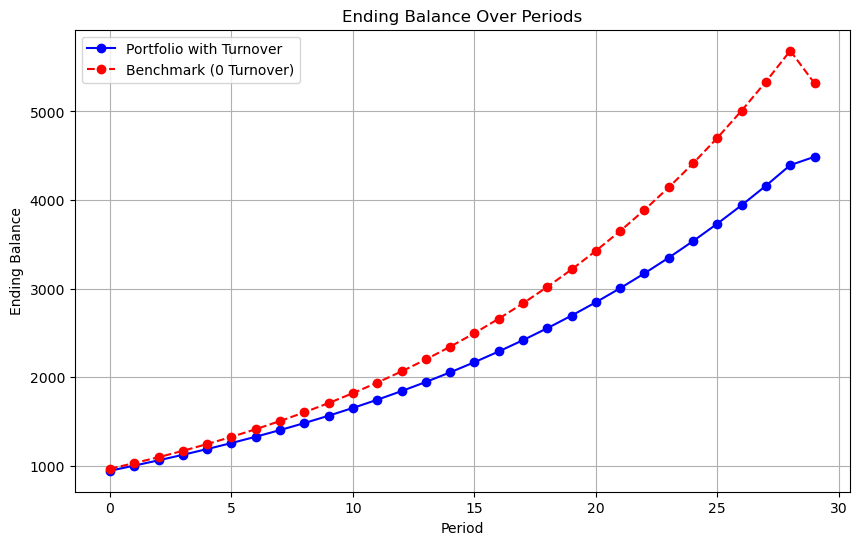

,Ending Balance,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
0,"$4,488.50","$5,318.00",$829.50,5.13%,5.73%,7.73%,2.00%


,Period,Beginning Balance,Beginning Cost Basis,Investment Return,Dividend Income,Realized Gain/Loss,Tax Cost,Ending Cost Basis,Ending Balance,Benchmark Beginning Balance,Benchmark Cost Basis,Benchmark Investment Return,Benchmark Dividend Income,Benchmark Realized Gain/Loss,Benchmark Tax Cost,Benchmark Ending Cost Basis,Benchmark Ending Balance
0,1,1000.000000,500.000000,70.000000,23.100000,505.862500,127.291656,901.670844,942.708344,1000.000000,500.000000,70.000000,23.100000,500.00000,104.620000,918.480000,965.380000
1,2,942.708344,901.670844,65.989584,21.776563,15.786003,8.183418,931.049991,1000.514510,965.380000,918.480000,67.576600,22.300278,0.00000,4.460056,936.320222,1028.496544
2,3,1000.514510,931.049991,70.036016,23.111885,23.231646,10.256051,967.137471,1060.294474,1028.496544,936.320222,71.994758,23.758270,0.00000,4.751654,955.326839,1095.739648
3,4,1060.294474,967.137471,74.220613,24.492802,29.505227,12.053578,1009.081922,1122.461509,1095.739648,955.326839,76.701775,25.311586,0.00000,5.062317,975.576107,1167.379107
4,5,1122.461509,1009.081922,78.572306,25.928861,34.925327,13.655164,1056.280947,1187.378651,1167.379107,975.576107,81.716537,26.966457,0.00000,5.393291,997.149273,1243.702353
5,6,1187.378651,1056.280947,83.116506,27.428447,39.735433,15.121532,1108.323295,1255.373624,1243.702353,997.149273,87.059165,28.729524,0.00000,5.745905,1020.132893,1325.015613
6,7,1255.373624,1108.323295,87.876154,28.999131,44.122210,16.499462,1164.945174,1326.750316,1325.015613,1020.132893,92.751093,30.607861,0.00000,6.121572,1044.619181,1411.645133
7,8,1326.750316,1164.945174,92.872522,30.647932,48.229359,17.825206,1225.997259,1401.797632,1411.645133,1044.619181,98.815159,32.609003,0.00000,6.521801,1070.706383,1503.938492
8,9,1401.797632,1225.997259,98.125834,32.381525,52.168132,19.127077,1291.419839,1480.796389,1503.938492,1070.706383,105.275694,34.740979,0.00000,6.948196,1098.499167,1602.265991
9,10,1480.796389,1291.419839,103.655747,34.206397,56.025306,20.427416,1361.224126,1564.024720,1602.265991,1098.499167,112.158619,37.012344,0.00000,7.402469,1128.109042,1707.022141


In [104]:
calc = TaxIllCalculator1(periods=30, beginning_balance=1000, beginning_cost = 500, liquidation = True, st_port_liq = True, st_bench_liq = True)
calc.calculate_portfolio()
calc.calculate_benchmark()
calc.calculate_breakeven_performance()
calc.plot_results()
calc.display_summary()
calc.display_full_results()